In [ ]:
#Limited training data

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1250 - loss: 2.4309 - val_accuracy: 0.0000e+00 - val_loss: 48.2695
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.2500 - loss: 22.6195 - val_accuracy: 0.0000e+00 - val_loss: 41.3836
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.1250 - loss: 19.8168 - val_accuracy: 0.0000e+00 - val_loss: 35.7296
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.0000e+00 - loss: 18.5472 - val_accuracy: 0.0000e+00 - val_loss: 28.2391
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.2500 - loss: 13.7308 - val_accuracy: 0.0000e+00 - val_loss: 19.6546
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.1250 - loss: 7.7558 - val_accuracy: 0.0000e+00 - val_loss: 13.4682
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.2500 - loss: 4.3688 - val_accuracy: 0.0000e+00 - val_loss: 9.6915
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.0000e+00 - loss: 5.1535 - 

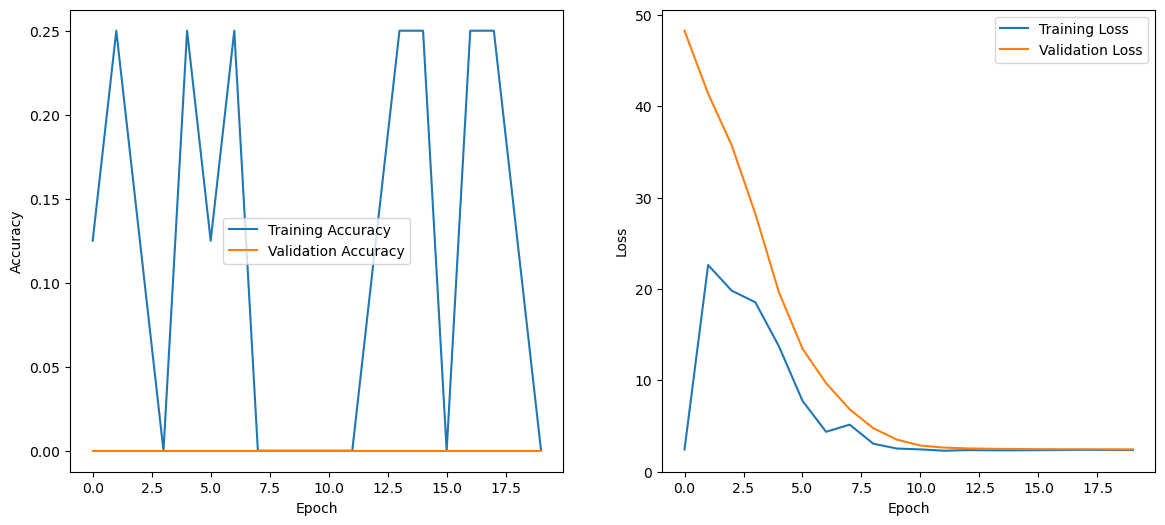

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pydicom as dicom
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set the path to your DICOM folder and load DICOM files
folder_path = '/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084'
dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]

# Load the label data
label_df = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

# Extract the study_id from the folder path
study_id = int(folder_path.split('/')[-2])

# Filter label data for the current study_id
study_labels = label_df[label_df['study_id'] == study_id]

# Load the images and labels
images = []
labels = []

for dicom_file in dicom_files:
    dicom_file_path = os.path.join(folder_path, dicom_file)
    dicom_data = dicom.dcmread(dicom_file_path)
    image = dicom_data.pixel_array
    images.append(image)
    
    # Extract instance number from the file name (assuming the file name format is instance_number.dcm)
    instance_number = int(dicom_file.split('.')[0])
    
    # Get the corresponding condition and level for the current instance_number
    matching_rows = study_labels[study_labels['instance_number'] == instance_number]
    
    if not matching_rows.empty:
        condition = matching_rows['condition'].values[0]
        level = matching_rows['level'].values[0]
        # Combine condition and level to form a unique label
        combined_label = f"{condition}_{level}"
    else:
        combined_label = "unknown"  # or any default label, you can skip this image if needed
    
    labels.append(combined_label)

# Remove images with 'unknown' labels if they were added
images = [img for img, lbl in zip(images, labels) if lbl != "unknown"]
labels = [lbl for lbl in labels if lbl != "unknown"]

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert lists to numpy arrays and normalize pixel values
images = np.array(images)
images = images / 255.0  # Normalize pixel values

# Convert labels to categorical (adjust num_classes based on the number of unique labels)
num_classes = len(label_encoder.classes_)
labels_encoded = to_categorical(labels_encoded, num_classes=num_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Reshape the data to add a channel dimension
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(-1, X_val.shape[1], X_val.shape[2], 1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20, validation_data=(X_val, y_val))

# Plot the training and validation accuracy and loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Limited training data

Index(['study_id', 'series_id', 'instance_number', 'condition', 'level', 'x',
       'y'],
      dtype='object')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1250 - loss: 2.3627 - val_accuracy: 0.0000e+00 - val_loss: 102.7255
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.2500 - loss: 29.0144 - val_accuracy: 0.0000e+00 - val_loss: 113.1312
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.1250 - loss: 37.2536 - val_accuracy: 0.0000e+00 - val_loss: 84.9894
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6250 - loss: 12.3357 - val_accuracy: 0.0000e+00 - val_loss: 72.8031
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6250 - loss: 8.2502 - val_accuracy: 0.0000e+00 - val_loss: 54.7719
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5000 - loss: 7.8453 - val_accuracy: 0.0000e+00 - val_loss: 45.0162
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7500 - loss: 4.2663 - val_accuracy: 0.0000e+00 - val_loss: 36.5887
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6250 - loss: 2.30

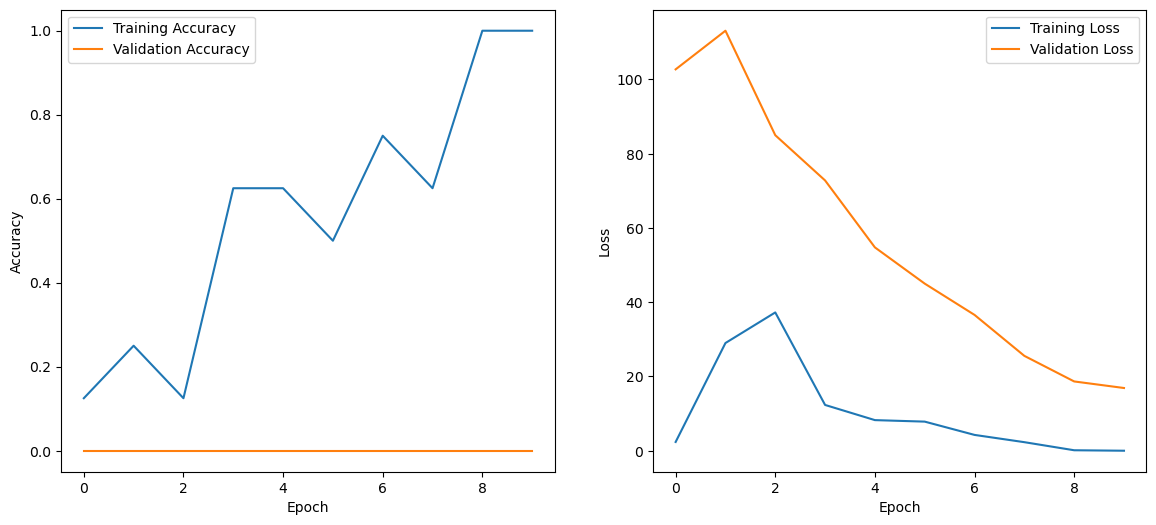

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pydicom as dicom
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set the path to your DICOM folder and load DICOM files
folder_path = '/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084'
dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]

# Load the label data
label_df = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

# Extract the study_id from the folder path
study_id = int(folder_path.split('/')[-2])

# Filter label data for the current study_id
study_labels = label_df[label_df['study_id'] == study_id]

# Print column names to verify
print(study_labels.columns)

# Load the images and labels
images = []
labels = []

for dicom_file in dicom_files:
    dicom_file_path = os.path.join(folder_path, dicom_file)
    dicom_data = dicom.dcmread(dicom_file_path)
    image = dicom_data.pixel_array
    images.append(image)
    
    # Extract instance number from the file name (assuming the file name format is instance_number.dcm)
    instance_number = int(dicom_file.split('.')[0])
    
    # Get the corresponding condition and level for the current instance_number
    matching_rows = study_labels[study_labels['instance_number'] == instance_number]
    
    if not matching_rows.empty:
        condition = matching_rows['condition'].values[0]
        level = matching_rows['level'].values[0]
        # Combine condition and level to form a unique label
        combined_label = f"{condition}_{level}"
    else:
        # Handle case where no matching instance_number is found
        combined_label = "unknown"  # or any default label, you can skip this image if needed
    
    labels.append(combined_label)

# Remove images with 'unknown' labels if they were added
images = [img for img, lbl in zip(images, labels) if lbl != "unknown"]
labels = [lbl for lbl in labels if lbl != "unknown"]

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert lists to numpy arrays and normalize pixel values
images = np.array(images)
images = images / 255.0  # Normalize pixel values

# Convert labels to categorical (adjust num_classes based on the number of unique labels)
num_classes = len(label_encoder.classes_)
labels_encoded = to_categorical(labels_encoded, num_classes=num_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Reshape the data to add a channel dimension
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(-1, X_val.shape[1], X_val.shape[2], 1)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust num_classes based on your dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Plot the training and validation accuracy and loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
#First baseline CNN

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 184s 132ms/step - accuracy: 0.1626 - loss: 2.9612 - val_accuracy: 0.2741 - val_loss: 2.5518
Epoch 2/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 181s 130ms/step - accuracy: 0.3030 - loss: 2.4035 - val_accuracy: 0.3086 - val_loss: 2.4071
Epoch 3/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 182s 131ms/step - accuracy: 0.3940 - loss: 1.9998 - val_accuracy: 0.3108 - val_loss: 2.3818
Epoch 4/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 180s 130ms/step - accuracy: 0.5402 - loss: 1.4470 - val_accuracy: 0.2838 - val_loss: 2.6914
Epoch 5/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 185s 133ms/step - accuracy: 0.7227 - loss: 0.8659 - val_accuracy: 0.2871 - val_loss: 3.3051
Epoch 6/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 300s 216ms/step - accuracy: 0.8744 - loss: 0.4277 - val_accuracy: 0.2827 - val_loss: 4.1028
Epoch 7/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 180s 130ms/step - accuracy: 0.9395 - loss: 0.2273 - val_accuracy: 0.2910 - val_loss: 5.1052
Epoch 8/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 178s 128ms/step - ac

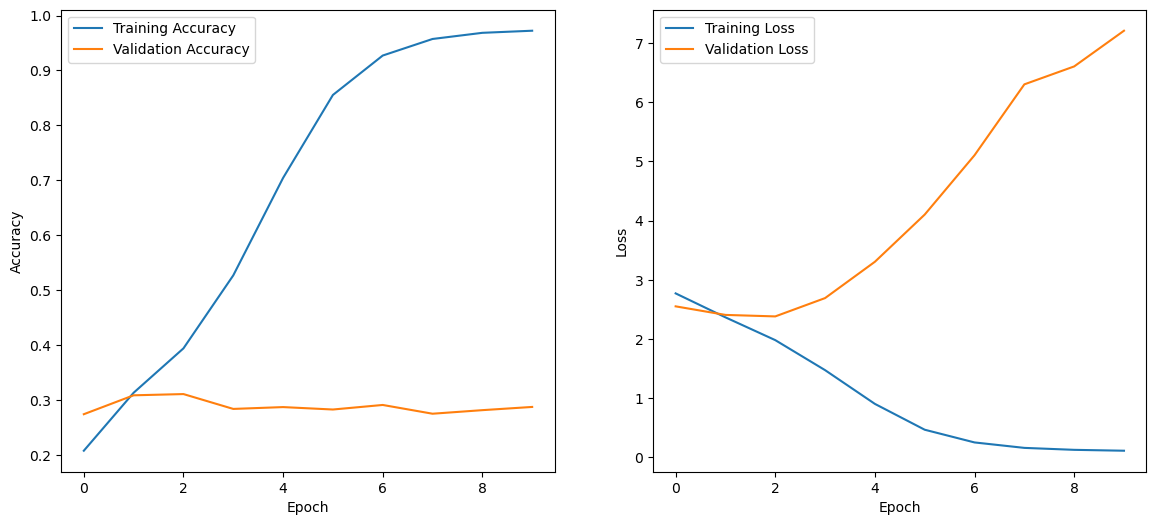

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pydicom as dicom
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2

# Set the path to the root DICOM folder
root_folder_path = '/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Load the label data
label_df = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

# Initialize lists to store images and labels
images = []
labels = []

# Specify desired width and height for resizing
desired_width = 128
desired_height = 128

# Iterate through each patient folder
for patient_folder in os.listdir(root_folder_path):
    patient_folder_path = os.path.join(root_folder_path, patient_folder)
    
    # Skip non-directory files
    if not os.path.isdir(patient_folder_path):
        continue
    
    # Iterate through each subfolder within the patient folder
    for subfolder in os.listdir(patient_folder_path):
        subfolder_path = os.path.join(patient_folder_path, subfolder)
        
        # Skip non-directory files
        if not os.path.isdir(subfolder_path):
            continue
        
        # Load DICOM files from the subfolder
        dicom_files = [f for f in os.listdir(subfolder_path) if f.endswith('.dcm')]
        
        # Extract the study_id from the folder name
        study_id = int(patient_folder)
        
        # Filter label data for the current study_id
        study_labels = label_df[label_df['study_id'] == study_id]
        
        # Iterate through DICOM files in the subfolder
        for dicom_file in dicom_files:
            dicom_file_path = os.path.join(subfolder_path, dicom_file)
            dicom_data = dicom.dcmread(dicom_file_path)
            image = dicom_data.pixel_array
            
            # Resize the image to the desired dimensions
            resized_image = cv2.resize(image, (desired_width, desired_height))
            images.append(resized_image)
            
            # Extract instance number from the file name
            instance_number = int(dicom_file.split('.')[0])
            
            # Get the corresponding condition and level for the current instance_number
            matching_rows = study_labels[study_labels['instance_number'] == instance_number]
            
            if not matching_rows.empty:
                condition = matching_rows['condition'].values[0]
                level = matching_rows['level'].values[0]
                # Combine condition and level to form a unique label
                combined_label = f"{condition}_{level}"
            else:
                # Handle case where no matching instance_number is found
                combined_label = "unknown"  # or any default label, you can skip this image if needed
            
            labels.append(combined_label)

# Remove images with 'unknown' labels if they were added
images = [img for img, lbl in zip(images, labels) if lbl != "unknown"]
labels = [lbl for lbl in labels if lbl != "unknown"]

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert lists to numpy arrays and normalize pixel values
images = np.array(images)
images = images / 255.0  # Normalize pixel values

# Convert labels to categorical (adjust num_classes based on the number of unique labels)
num_classes = len(label_encoder.classes_)
labels_encoded = to_categorical(labels_encoded, num_classes=num_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Reshape the data to add a channel dimension
X_train = X_train.reshape(-1, desired_width, desired_height, 1)
X_val = X_val.reshape(-1, desired_width, desired_height, 1)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(desired_width, desired_height, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust num_classes based on your dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Plot the training and validation accuracy and loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [2]:
#CNN with data augmentation and weights

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1388/1388 ━━━━━━━━━━━━━━━━━━━━ 198s 141ms/step - accuracy: 0.0364 - loss: 3.2822 - val_accuracy: 0.0469 - val_loss: 3.2021
Epoch 2/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 184s 132ms/step - accuracy: 0.0542 - loss: 3.1765 - val_accuracy: 0.0456 - val_loss: 3.1380
Epoch 3/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 183s 132ms/step - accuracy: 0.0476 - loss: 3.1917 - val_accuracy: 0.0533 - val_loss: 3.0690
Epoch 4/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 183s 132ms/step - accuracy: 0.0636 - loss: 3.1240 - val_accuracy: 0.0801 - val_loss: 3.0261
Epoch 5/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 183s 132ms/step - accuracy: 0.0720 - loss: 3.0933 - val_accuracy: 0.0948 - val_loss: 3.0298
Epoch 6/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 183s 132ms/step - accuracy: 0.0805 - loss: 3.0646 - val_accuracy: 0.0898 - val_loss: 3.0110
Epoch 7/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 202s 145ms/step - accuracy: 0.0806 - loss: 3.0754 - val_accuracy: 0.1180 - val_loss: 2.9714
Epoch 8/10
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 190s 137ms/step - accuracy: 0.0

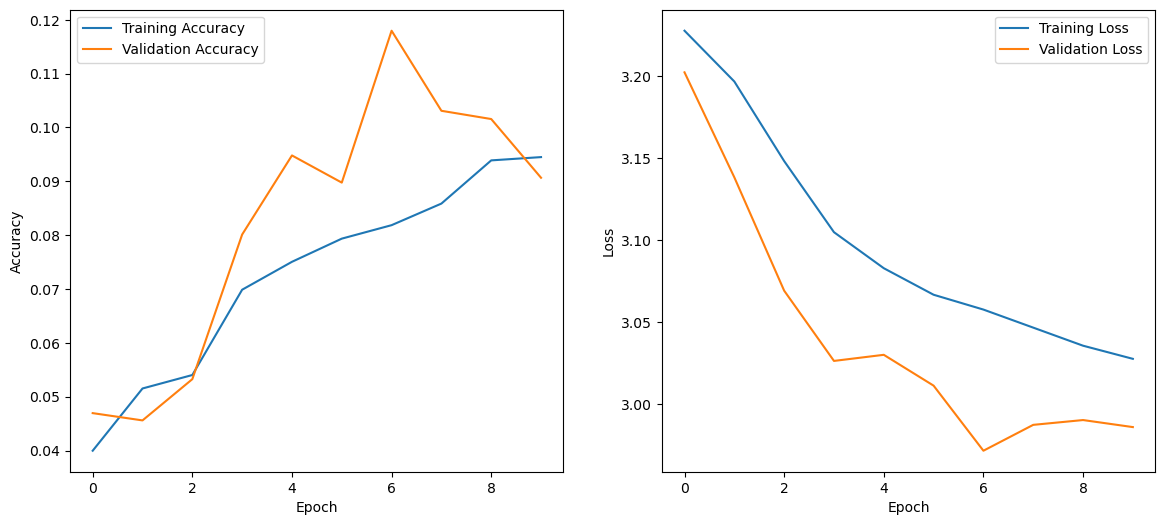

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pydicom as dicom
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import cv2

# Set the path to the root DICOM folder
root_folder_path = '/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Load the label data
label_df = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

# Initialize lists to store images and labels
images = []
labels = []

# Specify desired width and height for resizing
desired_width = 128
desired_height = 128

# Iterate through each patient folder
for patient_folder in os.listdir(root_folder_path):
    patient_folder_path = os.path.join(root_folder_path, patient_folder)
    
    # Skip non-directory files
    if not os.path.isdir(patient_folder_path):
        continue
    
    # Iterate through each subfolder within the patient folder
    for subfolder in os.listdir(patient_folder_path):
        subfolder_path = os.path.join(patient_folder_path, subfolder)
        
        # Skip non-directory files
        if not os.path.isdir(subfolder_path):
            continue
        
        # Load DICOM files from the subfolder
        dicom_files = [f for f in os.listdir(subfolder_path) if f.endswith('.dcm')]
        
        # Extract the study_id from the folder name
        study_id = int(patient_folder)
        
        # Filter label data for the current study_id
        study_labels = label_df[label_df['study_id'] == study_id]
        
        # Iterate through DICOM files in the subfolder
        for dicom_file in dicom_files:
            dicom_file_path = os.path.join(subfolder_path, dicom_file)
            dicom_data = dicom.dcmread(dicom_file_path)
            image = dicom_data.pixel_array
            
            # Resize the image to the desired dimensions
            resized_image = cv2.resize(image, (desired_width, desired_height))
            images.append(resized_image)
            
            # Extract instance number from the file name
            instance_number = int(dicom_file.split('.')[0])
            
            # Get the corresponding condition and level for the current instance_number
            matching_rows = study_labels[study_labels['instance_number'] == instance_number]
            
            if not matching_rows.empty:
                condition = matching_rows['condition'].values[0]
                level = matching_rows['level'].values[0]
                # Combine condition and level to form a unique label
                combined_label = f"{condition}_{level}"
            else:
                # Handle case where no matching instance_number is found
                combined_label = "unknown"  # or any default label, you can skip this image if needed
            
            labels.append(combined_label)

# Remove images with 'unknown' labels if they were added
images = [img for img, lbl in zip(images, labels) if lbl != "unknown"]
labels = [lbl for lbl in labels if lbl != "unknown"]

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert lists to numpy arrays and normalize pixel values
images = np.array(images)
images = images / 255.0  # Normalize pixel values

# Convert labels to categorical (adjust num_classes based on the number of unique labels)
num_classes = len(label_encoder.classes_)
labels_encoded = to_categorical(labels_encoded, num_classes=num_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Reshape the data to add a channel dimension
X_train = X_train.reshape(-1, desired_width, desired_height, 1)
X_val = X_val.reshape(-1, desired_width, desired_height, 1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels_encoded.argmax(axis=1)), y=labels_encoded.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(desired_width, desired_height, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust num_classes based on your dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation and class weights
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict)

# Plot the training and validation accuracy and loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
